In [ ]:
%%script true

# code for running on google collab

!pip install scikit-plot
!pip install fuzzywuzzy
!pip install catboost
!pip install optuna
!pip uninstall scikit-learn -y
!pip install scikit-learn
!pip install utm

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/black-cat'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.3 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=3e9cbd199671e92548c6b0b723244aa5200dbd35b6a6c55fac6c849b3152ba10
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [ ]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point
import numpy as np
from scipy.spatial import distance_matrix,distance
from catboost import CatBoostClassifier, EFeaturesSelectionAlgorithm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pickle
import os

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import random
import re
import sqlite3
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report,balanced_accuracy_score,accuracy_score,recall_score,precision_score,precision_recall_curve,f1_score,cohen_kappa_score,roc_auc_score,auc
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from scipy.optimize import minimize

import scikitplot as skplt
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
# from pandas_profiling import ProfileReport

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from xgboost import plot_importance



%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

In [ ]:
fires_df = pd.read_csv("data.csv", index_col=0)
train, test = train_test_split(fires_df, test_size=0.2, random_state=42)


# Pre-Processing

## Handling Missing Values

#### FIPS Codes
Add correct FIPS codes when county is available, based on the county and state , otherwise complete the missing values with the most closest location based on the latitude and longitude.

In [ ]:
from scipy.spatial.distance import cdist

def fill_fips_code(data):
    state_county_df = pd.read_csv("datasets/state_county_long_lat.csv")
    state_county_df["fips_code"] = state_county_df["fips_code"].astype(str).str.zfill(5)
    state_county_df["county_code"] = state_county_df["fips_code"].str[-3:]
    fips_by_state_county = state_county_df.groupby(["state", "county_code"])["fips_code"]
    data_fips = data["FIPS_CODE"].convert_dtypes().astype(str)

    # Fill in known FIPS codes
    for i, code in enumerate(zip(data["STATE"], data_fips.str.zfill(3))):
        if code in fips_by_state_county.groups:
            data_fips.iloc[i] = fips_by_state_county.get_group(code).iloc[0]

    # Fill in missing FIPS codes
    for i, row in data.loc[data["FIPS_CODE"].isnull()].iterrows():
        state = row["STATE"]
        lat, lng = row["LATITUDE"], row["LONGITUDE"]
        state_counties = state_county_df[state_county_df["state"] == state]
        closest_county_idx = cdist([[lat, lng]], state_counties[["lat", "long"]], "euclidean").argmin()
        data_fips[i] = state_counties.iloc[closest_county_idx]["fips_code"]

    data["FIPS_CODE"] = data_fips.astype(str)
    return data


train = fill_fips_code(train)
test = fill_fips_code(test)

#### DISCOVERY_TIME
Filling the missing values in the features discovery time, contained date, contained day of week and contained time. its done using random forest regressor model trained on the features discovery date, fire size, fire size class, latitude and longitude.

In [ ]:
def time_change(data):
    def split_time(time):
        if pd.isnull(time):
            return None, None
        else:
            time_str = str(time).zfill(4)  # Ensure time is represented as 4 digits
            time_float = float(time_str)
            hour = int(time_float // 100)  # Extract integer part for hour
            minute = int(time_float % 100)  # Extract integer part for minute
            return hour, minute

    data["DISCOVERY_HOUR"], data["DISCOVERY_MINUTE"] = zip(*data["DISCOVERY_TIME"].apply(split_time))
    data["CONT_HOUR"], data["CONT_MINUTE"] = zip(*data["CONT_TIME"].apply(split_time))
    return data


train = time_change(train)
test = time_change(test)

missing_features = ["DISCOVERY_HOUR", "DISCOVERY_MINUTE", "CONT_DATE", "CONT_HOUR", "CONT_MINUTE"]
model_features = ["DISCOVERY_DATE", "FIRE_SIZE", "LATITUDE", "LONGITUDE"]

We built a model and checked its performance for each feature using the model's scoring method. Now, this model is used to fill in the missing values for the features: *DISCOVERY_HOUR*, *DISCOVERY_MINUTE*, *CONT_DATE*, *CONT_HOUR*, and *CONT_MINUTE*

In [ ]:
def fill_missing(test, missing_features, model_features, train=None):
    def save_model(model_features, feature):
        not_null_data = train[train[feature].notnull()]
        X_train = not_null_data[model_features]
        y_train = not_null_data[feature]
        model = RandomForestRegressor(n_estimators=10)
        model.fit(X_train, y_train)
        with open(f"temp/{feature}.pkl", "wb") as f:
            pickle.dump(model, f)

    def load_model(feature):
        with open(f"temp/{feature}.pkl", "rb") as f:
            return pickle.load(f)

    def fill_missing_train(train, missing_features, model_features):
        for feature in missing_features:
            save_model(model_features, feature)
            model = load_model(feature)
            data = train.loc[train[feature].isnull(), model_features]
            train.loc[train[feature].isnull(), feature] = model.predict(data)
        return train

    def fill_missing_test(test, missing_features, model_features):
        for feature in missing_features:
            model = load_model(feature)
            data = test.loc[test[feature].isnull(), model_features]
            test.loc[test[feature].isnull(), feature] = model.predict(data)
            os.remove(f"temp/{feature}.pkl")
        return test

    if train is not None:
        train = fill_missing_train(train, missing_features, model_features)
    test = fill_missing_test(test, missing_features, model_features)
    return train, test


train, test = fill_missing(test, missing_features, model_features, train)

Fix wrong predictions for *CONT_DATE* and *CONT_DOY*.

In [ ]:
def fix_bad_data(data):
    data.loc[data["CONT_DATE"] < data["DISCOVERY_DATE"], "CONT_DATE"] = data.loc[
        data["CONT_DATE"] < data["DISCOVERY_DATE"], "DISCOVERY_DATE"
    ]
    data["CONT_DATE"] = data["CONT_DATE"].apply(lambda x: round(x * 2) / 2)
    data["CONT_DOY"] = pd.to_datetime(data["CONT_DATE"], unit="D", origin="julian").dt.dayofyear
    data = data.round({"DISCOVERY_HOUR": 0, "DISCOVERY_MINUTE": 0, "CONT_HOUR": 0, "CONT_MINUTE": 0})
    return data


train = fix_bad_data(train)
test = fix_bad_data(test)

## More pre processing for XGBoost

In [ ]:
%%script true

train = pd.read_csv("base_train_data.csv", index_col=0)
test = pd.read_csv("base_test_data.csv", index_col=0)

In [ ]:
train = train.drop_duplicates()

In [ ]:
most_common_list = ["USGAGAS", "USTXTXS", "USNCNCS", "USFLFLS", "USNYNYX", "USMSMSS", "USALALS", "USSCSCS"]

# Define a function to categorize NWCG_REPORTING_UNIT_ID
def categorize_unit_id(unit_id):
    if unit_id in most_common_list:
        return unit_id
    else:
        return "other"

# Apply the function to the NWCG_REPORTING_UNIT_ID column
train["NWCG_REPORTING_UNIT_ID"] = train["NWCG_REPORTING_UNIT_ID"].apply(lambda x: categorize_unit_id(x))
test["NWCG_REPORTING_UNIT_ID"] = test["NWCG_REPORTING_UNIT_ID"].apply(lambda x: categorize_unit_id(x))

In [ ]:
def categorize_fire_size_class(fire_class):
    if fire_class in ["A", "B", "C"]:
        return fire_class
    else:
        return "D"

# Apply the function to the NWCG_REPORTING_UNIT_ID column
train["FIRE_SIZE_CLASS"] = train["FIRE_SIZE_CLASS"].apply(lambda x: categorize_fire_size_class(x))
test["FIRE_SIZE_CLASS"] = test["FIRE_SIZE_CLASS"].apply(lambda x: categorize_fire_size_class(x))

In [ ]:
state_to_group = {
    # Group 1 - West Coast
    'CA': 'West Coast',
    'OR': 'West Coast',
    'WA': 'West Coast',
    'AK': 'West Coast',
    'HI': 'West Coast',

    # Group 2 - Western States
    'UT': 'Western States',
    'ID': 'Western States',
    'NV': 'Western States',
    'CO': 'Western States',
    'NM': 'Western States',
    'MT': 'Western States',
    'WY': 'Western States',
    'AZ': 'Western States',

    # Group 3 - Midwest
    'ND': 'Midwest',
    'SD': 'Midwest',
    'NE': 'Midwest',
    'KS': 'Midwest',
    'MN': 'Midwest',
    'IA': 'Midwest',
    'MO': 'Midwest',
    'WI': 'Midwest',
    'IL': 'Midwest',
    'MI': 'Midwest',
    'IN': 'Midwest',
    'OH': 'Midwest',

    # Group 4 - South
    'TX': 'South',
    'LA': 'South',
    'MS': 'South',
    'AL': 'South',
    'FL': 'South',
    'GA': 'South',
    'SC': 'South',
    'NC': 'South',
    'TN': 'South',
    'KY': 'South',
    'AR': 'South',
    'VA': 'South',
    'WV': 'South',
    'OK': 'South',

    # Group 5 - Northeast
    'ME': 'Northeast',
    'NH': 'Northeast',
    'VT': 'Northeast',
    'MA': 'Northeast',
    'RI': 'Northeast',
    'CT': 'Northeast',
    'NY': 'Northeast',
    'NJ': 'Northeast',
    'PA': 'Northeast',
    'DE': 'Northeast',
    'MD': 'Northeast',
    'DC': 'Northeast',

    # Group 6 - Territories
    'PR': 'Territories',
    'GU': 'Territories',
    'VI': 'Territories',
    'AS': 'Territories',
    'MP': 'Territories'
}

# Map the "STATE" column to the corresponding group
train['STATE_GROUP'] = train['STATE'].map(state_to_group)
test['STATE_GROUP'] = test['STATE'].map(state_to_group)

Encoding for XGBoost

In [ ]:
features = ['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', "OWNER_CODE"]

target = "STAT_CAUSE_DESCR"

In [ ]:
def label_encode(train, test, cat_features):
    combined = pd.concat([train, test], axis=0, ignore_index=True)
    encoder = LabelEncoder()

    for feature in cat_features:
        combined[feature] = encoder.fit_transform(combined[feature])

    train_final = combined.iloc[:len(train)]
    test_final = combined.iloc[len(train):]

    return train_final, test_final, cat_features

In [ ]:
train,test,features_new = label_encode(train,test,["STATE_GROUP", "FIRE_SIZE_CLASS", "SOURCE_SYSTEM_TYPE", "NWCG_REPORTING_UNIT_ID"])
features += features_new


# Feature Engineering

Adding FIRE_MONTH feature to join new datasets

In [ ]:
train["FIRE_MONTH"] = pd.to_datetime(train["DISCOVERY_DATE"], unit="D", origin="julian").dt.month
test["FIRE_MONTH"] = pd.to_datetime(test["DISCOVERY_DATE"], unit="D", origin="julian").dt.month

## Temperatures

In [ ]:
temperatures_df = pd.read_csv("datasets/city_temperature.csv")
temperatures_df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [ ]:
temperatures_df = temperatures_df[temperatures_df['Region'] == "North America"]
temperatures_df = temperatures_df[['State', 'Month', 'Year', 'AvgTemperature']]
temperatures_df = temperatures_df.dropna(subset=['State'])

temperatures_df.head()

,State,Month,Year,AvgTemperature
1450990,Alabama,1,1995,50.7
1450991,Alabama,1,1995,37.2
1450992,Alabama,1,1995,33.2
1450993,Alabama,1,1995,33.3
1450994,Alabama,1,1995,26.4


In [ ]:
state_mapping = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'Additional Territories': 'Territories'  # Assuming 'Additional Territories' maps to 'Territories'
}

# Step 2: Map the full state names in temperatures_df to their corresponding abbreviations
temperatures_df['State_Abbreviation'] = temperatures_df['State'].map(state_mapping)


In [ ]:
temperatures_df['AvgTemperature_State_Year_Month'] = temperatures_df.groupby(['State_Abbreviation', 'Year', 'Month'])['AvgTemperature'].transform('mean')
temperatures_df.head()

,State,Month,Year,AvgTemperature,State_Abbreviation,AvgTemperature_State_Year_Month
1450990,Alabama,1,1995,50.7,AL,46.151613
1450991,Alabama,1,1995,37.2,AL,46.151613
1450992,Alabama,1,1995,33.2,AL,46.151613
1450993,Alabama,1,1995,33.3,AL,46.151613
1450994,Alabama,1,1995,26.4,AL,46.151613


In [ ]:
grouped_temps = temperatures_df.groupby(['State_Abbreviation', 'Year', 'Month'])['AvgTemperature_State_Year_Month'].mean().reset_index()

# Merge the grouped temperatures with train on state, year, and month
merged_train = pd.merge(train, grouped_temps, how='left', left_on=['STATE', 'FIRE_YEAR', 'FIRE_MONTH'], right_on=['State_Abbreviation', 'Year', 'Month'])

# Drop redundant columns
merged_train.drop(columns=['State_Abbreviation', 'Year', 'Month'], inplace=True)

# Rename the merged column
merged_train.rename(columns={'AvgTemperature_State_Year_Month': 'AvgTemperature_State_Year_Month'}, inplace=True)

merged_train.head()

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,FIPS_CODE,FIPS_NAME,Shape,DISCOVERY_HOUR,DISCOVERY_MINUTE,CONT_HOUR,CONT_MINUTE,STATE_GROUP,FIRE_MONTH,AvgTemperature_State_Year_Month
0,875230,ODF-74995,2,ST-ORORS,ST/C&L,8,Lake Unit,ORODF-982,Lake Unit,011,...,41037,Lake,b'\x00\x01\xad\x10\x00\x00<\xcb\xf3\xe0\xee.^\...,14.0,19.0,20.0,23.0,4,7,71.348387
1,1397998,FS-1484491,0,FS-FIRESTAT,FS,8,National Forests in North Carolina,0811,National Forests in North Carolina,001,...,37123,Montgomery,b'\x00\x01\xad\x10\x00\x00LpV\xe9\x93\xf6S\xc0...,14.0,30.0,17.0,0.0,2,1,35.609677
2,1806431,SFO-NY-NY0401-2004-3492,2,ST-NASF,ST/C&L,5,Fire Department of New York,NY0401,Fire Department of New York,NaN,...,36007,Broome,b'\x00\x01\xad\x10\x00\x00\x98\xf5\xef\x1b\xdb...,14.0,22.0,14.0,22.0,1,6,65.865333
3,201206021,2011TDA10059,2,ST-NASF,ST/C&L,8,Tennessee Division of Forestry,TNTDA,Tennessee Department of Agriculture,NaN,...,47115,Marion,b'\x00\x01\xad\x10\x00\x00\xdc$\x06\x81\x95gU\...,14.0,0.0,15.0,26.0,2,8,81.737097
4,644326,SFO-TN01370606-6000060386,2,ST-NASF,ST/C&L,8,Tennessee Division of Forestry,TNTNS,Tennessee Division of Forestry,NaN,...,47005,Benton,b'\x00\x01\xad\x10\x00\x00\xd0\x9d\xab\xd6\x17...,15.0,15.0,17.0,12.0,2,4,65.785833


In [ ]:
merged_train['AvgTemperature_State_Year_Month'].unique()

array([71.3483871 , 35.60967742, 65.86533333, ..., 82.96612903,
       53.72857143, 22.39677419])

In [ ]:
first = train['STATE'].unique()
second = temperatures_df['State_Abbreviation'].unique()

first_set = set(first)
second_set = set(second)

# Find the states that are in the first list but not in the second list
states_not_in_second_list = first_set - second_set

print(states_not_in_second_list)

{'PR'}


In [ ]:
first = train['FIRE_YEAR'].unique()
second = temperatures_df['Year'].unique()

first_set = set(first)
second_set = set(second)

# Find the states that are in the first list but not in the second list
states_not_in_second_list = first_set - second_set

print(states_not_in_second_list)

{1992, 1993, 1994}


In [ ]:
check = merged_train[merged_train['FIRE_YEAR'] == 1993]
check.head()

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,FIPS_CODE,FIPS_NAME,Shape,DISCOVERY_HOUR,DISCOVERY_MINUTE,CONT_HOUR,CONT_MINUTE,STATE_GROUP,FIRE_MONTH,AvgTemperature_State_Year_Month
18,19102126,SFO-GA-FOR-39-5/10/1993-1405,2,ST-GAGAS,ST/C&L,2,Georgia Forestry Commission,GAGAS,Georgia Forestry Commission,NaN,...,13117,Forsyth,b'\x00\x01\xad\x10\x00\x00\xd8\xf9~j\xbc\x0cU\...,14.0,5.0,14.0,38.0,2,5,NaN
25,245925,W-242967,0,DOI-WFMI,NPS,8,Indiana Dunes National Lakeshore,INIDP,Indiana Dunes National Lakeshore,67,...,18127,NaN,b'\x00\x01\xad\x10\x00\x00\xe8\x12\xd5[\x03\xc...,21.0,27.0,22.0,35.0,0,10,NaN
26,891927,SCHMIDT_29008591,2,ST-MOMOS,ST/C&L,8,Missouri Department of Conservation,MOMOS,Missouri Department of Conservation,NaN,...,29029,Camden,b'\x00\x01\xad\x10\x00\x00\xe8\xb83vv2W\xc0\x8...,12.0,10.0,17.0,24.0,0,4,NaN
44,1316647,CDF_1993_56_2232_417,2,ST-CACDF,ST/C&L,8,Merced-Mariposa Unit,CAMMU,CDF - Merced-Mariposa Unit,NaN,...,6043,NaN,b'\x00\x01\xad\x10\x00\x00\x98\xab\x8b\x80o\xf...,18.0,19.0,15.0,23.0,4,8,NaN
111,1092167,TFS_FL_42483,2,ST-FLFLS,ST/C&L,1,Florida Forest Service,FLFLS6,FLS Suwannee Forestry Center,NaN,...,12003,Baker,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...,15.0,29.0,15.0,0.0,2,6,NaN


In [ ]:
subset_1995 = merged_train[(merged_train['FIRE_YEAR'] == 1995)]

# Group the subset by state and month and calculate the mean temperature for each group
mean_temps_1995 = subset_1995.groupby(['STATE', 'FIRE_MONTH'])['AvgTemperature_State_Year_Month'].mean().reset_index()

# Merge the mean temperatures with the original merged_train based on state and month
final_merged_train = pd.merge(merged_train, mean_temps_1995, how='left', on=['STATE', 'FIRE_MONTH'], suffixes=('', '_1995'))

# Fill NaN values in the AvgTemperature_State_Year_Month column with corresponding values from 2015
final_merged_train['AvgTemperature_State_Year_Month'].fillna(final_merged_train['AvgTemperature_State_Year_Month_1995'], inplace=True)

# Drop the redundant column
final_merged_train.drop(columns=['AvgTemperature_State_Year_Month_1995'], inplace=True)

In [ ]:
state_means = final_merged_train.groupby('STATE').agg({'LATITUDE': 'mean', 'LONGITUDE': 'mean'}).reset_index()

# Step 2: Calculate the mean latitude and longitude for the state 'PR'
pr_mean = state_means[state_means['STATE'] == 'PR']

state_means = state_means[state_means['STATE'] != 'PR']


# Step 3: Calculate the Euclidean distance between the mean latitude and longitude of 'PR' and the mean latitude and longitude of each state
state_means['distance_to_PR'] = np.sqrt((state_means['LATITUDE'] - pr_mean['LATITUDE'].values[0])**2 + (state_means['LONGITUDE'] - pr_mean['LONGITUDE'].values[0])**2)

# Step 4: Find the state with the minimum Euclidean distance
closest_state = state_means.loc[state_means['distance_to_PR'].idxmin()]

print("Closest state to Puerto Rico:")
print(closest_state)

Closest state to Puerto Rico:
STATE                    FL
LATITUDE          28.780405
LONGITUDE        -82.524546
distance_to_PR    19.358122
Name: 9, dtype: object


In [ ]:
subset_fl = final_merged_train[(final_merged_train['STATE'] == 'FL')]

# Group the subset by state and month and calculate the mean temperature for each group
mean_temps_fl = subset_fl.groupby(['FIRE_YEAR', 'FIRE_MONTH'])['AvgTemperature_State_Year_Month'].mean().reset_index()

# Merge the mean temperatures with the original merged_train based on state and month
final_merged_train = pd.merge(final_merged_train, mean_temps_fl, how='left', on=['FIRE_YEAR', 'FIRE_MONTH'], suffixes=('', '_FL'))

# Fill NaN values in the AvgTemperature_State_Year_Month column with corresponding values from 2015
final_merged_train['AvgTemperature_State_Year_Month'].fillna(final_merged_train['AvgTemperature_State_Year_Month_FL'], inplace=True)

# Drop the redundant column
final_merged_train.drop(columns=['AvgTemperature_State_Year_Month_FL'], inplace=True)

In [ ]:
mean_temps = final_merged_train.groupby(['STATE', 'FIRE_YEAR', 'FIRE_MONTH'])['AvgTemperature_State_Year_Month'].mean().reset_index()

# Merge the mean temperatures with the original train DataFrame based on STATE, FIRE_YEAR, and FIRE_MONTH
train = pd.merge(train, mean_temps, how='left', on=['STATE', 'FIRE_YEAR', 'FIRE_MONTH'])
#####TESTTTTTTTTTTTTTTTTTTTT
test = pd.merge(test, mean_temps, how='left', on=['STATE', 'FIRE_YEAR', 'FIRE_MONTH'])


In [ ]:
train.head()


,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,FIPS_CODE,FIPS_NAME,Shape,DISCOVERY_HOUR,DISCOVERY_MINUTE,CONT_HOUR,CONT_MINUTE,STATE_GROUP,FIRE_MONTH,AvgTemperature_State_Year_Month
0,875230,ODF-74995,2,ST-ORORS,ST/C&L,8,Lake Unit,ORODF-982,Lake Unit,011,...,41037,Lake,b'\x00\x01\xad\x10\x00\x00<\xcb\xf3\xe0\xee.^\...,14.0,19.0,20.0,23.0,4,7,71.348387
1,1397998,FS-1484491,0,FS-FIRESTAT,FS,8,National Forests in North Carolina,0811,National Forests in North Carolina,001,...,37123,Montgomery,b'\x00\x01\xad\x10\x00\x00LpV\xe9\x93\xf6S\xc0...,14.0,30.0,17.0,0.0,2,1,35.609677
2,1806431,SFO-NY-NY0401-2004-3492,2,ST-NASF,ST/C&L,5,Fire Department of New York,NY0401,Fire Department of New York,NaN,...,36007,Broome,b'\x00\x01\xad\x10\x00\x00\x98\xf5\xef\x1b\xdb...,14.0,22.0,14.0,22.0,1,6,65.865333
3,201206021,2011TDA10059,2,ST-NASF,ST/C&L,8,Tennessee Division of Forestry,TNTDA,Tennessee Department of Agriculture,NaN,...,47115,Marion,b'\x00\x01\xad\x10\x00\x00\xdc$\x06\x81\x95gU\...,14.0,0.0,15.0,26.0,2,8,81.737097
4,644326,SFO-TN01370606-6000060386,2,ST-NASF,ST/C&L,8,Tennessee Division of Forestry,TNTNS,Tennessee Division of Forestry,NaN,...,47005,Benton,b'\x00\x01\xad\x10\x00\x00\xd0\x9d\xab\xd6\x17...,15.0,15.0,17.0,12.0,2,4,65.785833


In [ ]:
train['AvgTemperature_in_celsius']=train['AvgTemperature_State_Year_Month'].map(lambda x: x-32 if x>0 else x+32) #Celsius
test['AvgTemperature_in_celsius']=test['AvgTemperature_State_Year_Month'].map(lambda x: x-32 if x>0 else x+32) #Celsius


In [ ]:
train['AvgTemperature_in_celsius'].isnull().sum()


0

In [ ]:
train.shape

(457140, 45)

### More temperature features

In [ ]:
train['Temperature_Deviation'] = train['AvgTemperature_in_celsius'] - train['AvgTemperature_in_celsius'].mean()
test['Temperature_Deviation'] = test['AvgTemperature_in_celsius'] - test['AvgTemperature_in_celsius'].mean()

summer_threshold = 25  # Example threshold for summer
winter_threshold = 10  # Example threshold for winter

# Create seasonality features
train['Is_Summer'] = ((train['FIRE_MONTH'].isin([6, 7, 8])) & (train['AvgTemperature_in_celsius'] >= summer_threshold)).astype(int)
train['Is_Winter'] = ((train['FIRE_MONTH'].isin([12, 1, 2])) & (train['AvgTemperature_in_celsius'] <= winter_threshold)).astype(int)

test['Is_Summer'] = ((test['FIRE_MONTH'].isin([6, 7, 8])) & (test['AvgTemperature_in_celsius'] >= summer_threshold)).astype(int)
test['Is_Winter'] = ((test['FIRE_MONTH'].isin([12, 1, 2])) & (test['AvgTemperature_in_celsius'] <= winter_threshold)).astype(int)

train.head()

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,DISCOVERY_MINUTE,CONT_HOUR,CONT_MINUTE,STATE_GROUP,FIRE_MONTH,AvgTemperature_State_Year_Month,AvgTemperature_in_celsius,Temperature_Deviation,Is_Summer,Is_Winter
0,875230,ODF-74995,2,ST-ORORS,ST/C&L,8,Lake Unit,ORODF-982,Lake Unit,011,...,19.0,20.0,23.0,4,7,71.348387,39.348387,9.314108,1,0
1,1397998,FS-1484491,0,FS-FIRESTAT,FS,8,National Forests in North Carolina,0811,National Forests in North Carolina,001,...,30.0,17.0,0.0,2,1,35.609677,3.609677,-26.424602,0,1
2,1806431,SFO-NY-NY0401-2004-3492,2,ST-NASF,ST/C&L,5,Fire Department of New York,NY0401,Fire Department of New York,NaN,...,22.0,14.0,22.0,1,6,65.865333,33.865333,3.831054,1,0
3,201206021,2011TDA10059,2,ST-NASF,ST/C&L,8,Tennessee Division of Forestry,TNTDA,Tennessee Department of Agriculture,NaN,...,0.0,15.0,26.0,2,8,81.737097,49.737097,19.702817,1,0
4,644326,SFO-TN01370606-6000060386,2,ST-NASF,ST/C&L,8,Tennessee Division of Forestry,TNTNS,Tennessee Division of Forestry,NaN,...,15.0,17.0,12.0,2,4,65.785833,33.785833,3.751554,0,0


## Smoking

In [ ]:
smoking_df = pd.read_csv("datasets/tobacco.csv")
smoking_df.head()

,Year,State,Smoke everyday,Smoke some days,Former smoker,Never smoked,Location 1
0,1996,Puerto Rico,9.40%,5.10%,16%,69.50%,Puerto Rico\n
1,1997,Puerto Rico,9.40%,5%,15.70%,69.90%,Puerto Rico\n
2,1998,Puerto Rico,10.10%,5.20%,16.80%,67.90%,Puerto Rico\n
3,1999,Puerto Rico,9.70%,4%,15.30%,71%,Puerto Rico\n
4,2000,Puerto Rico,9.20%,3.90%,15.20%,71.60%,Puerto Rico\n


In [ ]:
all_years = pd.DataFrame({'Year': range(1995, 2011)})

# Merge the DataFrame with all years with the filtered DataFrame
merged_df = all_years.merge(smoking_df, on='Year', how='left')

# Group by state and collect the missing years for each state
missing_years_by_state = merged_df.groupby('State')['Year'].apply(lambda x: sorted(set(all_years['Year']) - set(x.dropna())))

# Print states with missing years and the corresponding missing years
for state, missing_years in missing_years_by_state.items():
    if len(missing_years) > 0:
        print(f"State: {state}, Missing Years: {missing_years}")

State: District of Columbia, Missing Years: [1995]
State: Guam, Missing Years: [1995, 1996, 1997, 1998, 1999, 2000, 2004, 2005, 2006]
State: Hawaii, Missing Years: [2004]
State: Puerto Rico, Missing Years: [1995]
State: Utah, Missing Years: [1995, 1996]
State: Virgin Islands, Missing Years: [1995, 1996, 1997, 1998, 1999, 2000]


### Fill missing

In [ ]:
def fill_missing_year(smoking_df, state, year):
    following_year = year + 1
    exist_row_following_year = smoking_df[(smoking_df['State'] == state) & (smoking_df['Year'] == following_year)]

    # Create a copy of the existing row
    copy_row = exist_row_following_year.copy()
    copy_row['Year'] = year  # Update the year in the copied row

    # Append the copied row to the DataFrame
    smoking_df = pd.concat([smoking_df, copy_row], ignore_index=True)

    return smoking_df


smoking_df = fill_missing_year(smoking_df, "District of Columbia", 1995)
smoking_df = fill_missing_year(smoking_df, "Hawaii", 2004)
smoking_df = fill_missing_year(smoking_df, "Puerto Rico", 1995)
smoking_df = fill_missing_year(smoking_df, "Utah", 1996)
smoking_df = fill_missing_year(smoking_df, "Utah", 1995)



In [ ]:
exist_row_following_year = smoking_df[(smoking_df['State'] == "District of Columbia") & (smoking_df['Year'] == 1995)]
print(exist_row_following_year)

     Year                 State Smoke everyday Smoke some days Former smoker  \
876  1995  District of Columbia         14.90%           5.60%        17.80%   

    Never smoked                                         Location 1  
876       61.70%  District of Columbia\n(38.89036999987576, -77....  


In [ ]:
all_years = pd.DataFrame({'Year': range(1995, 2011)})

# Merge the DataFrame with all years with the filtered DataFrame
merged_df = all_years.merge(smoking_df, on='Year', how='left')

# Group by state and collect the missing years for each state
missing_years_by_state = merged_df.groupby('State')['Year'].apply(lambda x: sorted(set(all_years['Year']) - set(x.dropna())))

# Print states with missing years and the corresponding missing years
for state, missing_years in missing_years_by_state.items():
    if len(missing_years) > 0:
        print(f"State: {state}, Missing Years: {missing_years}")

State: Guam, Missing Years: [1995, 1996, 1997, 1998, 1999, 2000, 2004, 2005, 2006]
State: Virgin Islands, Missing Years: [1995, 1996, 1997, 1998, 1999, 2000]


In [ ]:
smoking_df['State'].unique()

array(['Puerto Rico', 'Virgin Islands', 'Louisiana', 'Nevada', 'Nebraska',
       'Vermont', 'Tennessee', 'Guam', 'Delaware', 'Oklahoma',
       'Washington', 'New York', 'South Dakota', 'Illinois', 'Indiana',
       'Connecticut', 'Montana', 'Missouri', 'Florida', 'North Carolina',
       'Utah', 'Hawaii', 'Georgia', 'Virginia', 'Massachusetts',
       'Alabama', 'Mississippi', 'California', 'Iowa', 'Idaho', 'Kansas',
       'Rhode Island', 'New Hampshire', 'New Mexico', 'Maryland',
       'Minnesota', 'Ohio', 'New Jersey', 'Texas', 'Arkansas', 'Alaska',
       'Michigan', 'Colorado', 'North Dakota', 'Arizona', 'Pennsylvania',
       'Wyoming', 'West Virginia', 'Kentucky', 'Oregon', 'South Carolina',
       'Wisconsin', 'Maine', 'District of Columbia',
       'Nationwide (States, DC, and Territories)',
       'Nationwide (States and DC)'], dtype=object)

In [ ]:
state_mapping = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'Virgin Islands': 'other', 'Guam': 'other', 'Nationwide (States, DC, and Territories)': 'other',
    'Nationwide (States and DC)': 'other'
}

# Step 2: Map the full state names in temperatures_df to their corresponding abbreviations
smoking_df['State_Abbreviation'] = smoking_df['State'].map(state_mapping)

In [ ]:
first = set(smoking_df['State_Abbreviation'].unique())
second = set(train['STATE'].unique())

first - second

{'other'}

In [ ]:
smoking_df['Smoke everyday'] = smoking_df['Smoke everyday'].str.rstrip('%').astype('float')
smoking_df['Smoke some days'] = smoking_df['Smoke some days'].str.rstrip('%').astype('float')

smoking_df['smokers_percentage'] = smoking_df['Smoke everyday'] + smoking_df['Smoke some days']

# Group by year and state, calculate the mean smoking rate for each group
smoking_df['avg_smoking_rate'] = smoking_df.groupby(['Year', 'State'])['smokers_percentage'].transform('mean')

In [ ]:
# Calculate the 33% and 66% quantiles for each year
quantile_33 = smoking_df.groupby('Year')['avg_smoking_rate'].quantile(0.33)
quantile_66 = smoking_df.groupby('Year')['avg_smoking_rate'].quantile(0.66)

# Function to assign smoking category based on quantiles
def assign_category(avg_rate, quantile_33, quantile_66):
    if avg_rate <= quantile_33:
        return -1
    elif avg_rate <= quantile_66:
        return 0
    else:
        return 1

# Create a new column for smoking category
smoking_df['smoking_category'] = smoking_df.apply(lambda x: assign_category(x['avg_smoking_rate'], quantile_33[x['Year']], quantile_66[x['Year']]), axis=1)

In [ ]:
def merge_smoking_df(df, smoking_df):

  grouped_smoking = smoking_df.groupby(['State_Abbreviation', 'Year'])['avg_smoking_rate'].mean().reset_index()

  # Merge the grouped temperatures with train on state, year, and month
  df = pd.merge(df, grouped_smoking, how='left', left_on=['STATE', 'FIRE_YEAR'], right_on=['State_Abbreviation', 'Year'])

  # Drop redundant columns
  df.drop(columns=['State_Abbreviation', 'Year'], inplace=True)

  # Rename the merged column
  df.rename(columns={'avg_smoking_rate': 'avg_smoking_rate'}, inplace=True)
  return df

train = merge_smoking_df(train, smoking_df)
test = merge_smoking_df(test, smoking_df)


We'll fill the missing year by the average smoking rates of the three years that are before (if it's 2011-2015) or after (if it's 1992-1994) them

In [ ]:
first = train['FIRE_YEAR'].unique()
second = smoking_df['Year'].unique()

first_set = set(first)
second_set = set(second)

# Find the states that are in the first list but not in the second list
states_not_in_second_list = first_set - second_set

print(states_not_in_second_list)

{1992, 1993, 1994, 2011, 2012, 2013, 2014, 2015}


In [ ]:
years_of_interest = [1995, 1996, 1997, 2008, 2009, 2010]

# Initialize the dictionary to store average smoking rates
state_year_avg_smoking_rate = {}

# Iterate over the years and states to calculate and store average smoking rates
for year in years_of_interest:
    # Filter smoking_df for the current year
    year_data = smoking_df[smoking_df['Year'] == year]

    # Iterate over the states in the current year
    for state, avg_smoking_rate in zip(year_data['State_Abbreviation'], year_data['avg_smoking_rate']):
        # Create a tuple of state and year as the key
        key = (state, year)

        # Add the avg_smoking_rate to the dictionary
        state_year_avg_smoking_rate[key] = avg_smoking_rate

print(state_year_avg_smoking_rate)

{('MS', 1995): 23.3, ('NH', 1995): 21.1, ('IA', 1995): 23.099999999999998, ('KS', 1995): 21.6, ('RI', 1995): 24.8, ('DE', 1995): 25.3, ('AK', 1995): 24.900000000000002, ('WI', 1995): 21.7, ('MO', 1995): 24.099999999999998, ('SC', 1995): 23.4, ('CT', 1995): 20.6, ('OH', 1995): 25.8, ('NV', 1995): 25.8, ('IN', 1995): 27.0, ('ND', 1995): 22.6, ('GA', 1995): 20.299999999999997, ('MT', 1995): 21.099999999999998, ('LA', 1995): 25.1, ('OK', 1995): 21.5, ('KY', 1995): 27.599999999999998, ('NE', 1995): 21.799999999999997, ('VA', 1995): 21.4, ('ME', 1995): 24.7, ('OR', 1995): 21.7, ('WA', 1995): 19.9, ('PA', 1995): 23.7, ('MN', 1995): 20.299999999999997, ('AZ', 1995): 22.7, ('FL', 1995): 23.0, ('NY', 1995): 21.3, ('CO', 1995): 21.5, ('NM', 1995): 20.700000000000003, ('SD', 1995): 21.7, ('WV', 1995): 25.599999999999998, ('MA', 1995): 21.6, ('MD', 1995): 21.1, ('AL', 1995): 24.0, ('AR', 1995): 25.0, ('WY', 1995): 22.0, ('HI', 1995): 17.6, ('ID', 1995): 19.6, ('VT', 1995): 22.099999999999998, ('NJ'

In [ ]:
for year in range(2011, 2016):
  for state in smoking_df['State_Abbreviation'].unique():
    mean_smoking_rate = 0
    for before_year in range(year - 3, year):
      key = (state, before_year)
      value = state_year_avg_smoking_rate[key]
      mean_smoking_rate += value
    mean_smoking_rate /= 3
    new_key = (state, year)
    state_year_avg_smoking_rate[new_key] = mean_smoking_rate

In [ ]:
for year in range(1994, 1991, -1):
  for state in smoking_df['State_Abbreviation'].unique():
    if state != 'other':
      mean_smoking_rate = 0
      for before_year in range(year + 1, year + 4):
        key = (state, before_year)
        value = state_year_avg_smoking_rate[key]
        mean_smoking_rate += value
      mean_smoking_rate /= 3
      new_key = (state, year)
      state_year_avg_smoking_rate[new_key] = mean_smoking_rate

In [ ]:
def fill_missing_avg_smoking_rate(row, state_year_avg_smoking_rate):
    state = row['STATE']
    year = row['FIRE_YEAR']
    if pd.isnull(row['avg_smoking_rate']) and (state, year) in state_year_avg_smoking_rate:
        return state_year_avg_smoking_rate[(state, year)]
    else:
        return row['avg_smoking_rate']

# Apply the function to fill missing values in train
train['avg_smoking_rate'] = train.apply(fill_missing_avg_smoking_rate, args=(state_year_avg_smoking_rate,), axis=1)

# Apply the function to fill missing values in test
test['avg_smoking_rate'] = test.apply(fill_missing_avg_smoking_rate, args=(state_year_avg_smoking_rate,), axis=1)

In [ ]:
if train['avg_smoking_rate'].isnull().any():
    print("There are NaN values in the avg_smoking_rate column.")
else:
    print("There are no NaN values in the avg_smoking_rate column.")


There are no NaN values in the avg_smoking_rate column.


In [ ]:
if test['avg_smoking_rate'].isnull().any():
    print("There are NaN values in the avg_smoking_rate column.")
else:
    print("There are no NaN values in the avg_smoking_rate column.")

There are no NaN values in the avg_smoking_rate column.


In [ ]:
# Function to assign smoking category based on quantiles
def assign_category(avg_rate, quantile_33, quantile_66):
    if avg_rate <= quantile_33:
        return 1
    elif avg_rate <= quantile_66:
        return 2
    else:
        return 3


# Calculate the 33% and 66% quantiles for each year
def smoking_category_feature(df):

  quantile_33 = df.groupby('FIRE_YEAR')['avg_smoking_rate'].quantile(0.33)
  quantile_66 = df.groupby('FIRE_YEAR')['avg_smoking_rate'].quantile(0.66)
  # Create a new column for smoking category
  df['smoking_category'] = df.apply(lambda x: assign_category(x['avg_smoking_rate'], quantile_33[x['FIRE_YEAR']], quantile_66[x['FIRE_YEAR']]), axis=1)


smoking_category_feature(train)
smoking_category_feature(test)


In [ ]:
train.head()

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,CONT_MINUTE,STATE_GROUP,FIRE_MONTH,AvgTemperature_State_Year_Month,AvgTemperature_in_celsius,Temperature_Deviation,Is_Summer,Is_Winter,avg_smoking_rate,smoking_category
0,875230,ODF-74995,2,ST-ORORS,ST/C&L,8,Lake Unit,ORODF-982,Lake Unit,011,...,23.0,4,7,71.348387,39.348387,9.314108,1,0,18.400000,2
1,1397998,FS-1484491,0,FS-FIRESTAT,FS,8,National Forests in North Carolina,0811,National Forests in North Carolina,001,...,0.0,2,1,35.609677,3.609677,-26.424602,0,1,19.700000,3
2,1806431,SFO-NY-NY0401-2004-3492,2,ST-NASF,ST/C&L,5,Fire Department of New York,NY0401,Fire Department of New York,NaN,...,22.0,1,6,65.865333,33.865333,3.831054,1,0,19.900000,1
3,201206021,2011TDA10059,2,ST-NASF,ST/C&L,8,Tennessee Division of Forestry,TNTDA,Tennessee Department of Agriculture,NaN,...,26.0,2,8,81.737097,49.737097,19.702817,1,0,21.733333,3
4,644326,SFO-TN01370606-6000060386,2,ST-NASF,ST/C&L,8,Tennessee Division of Forestry,TNTNS,Tennessee Division of Forestry,NaN,...,12.0,2,4,65.785833,33.785833,3.751554,0,0,22.500000,3


The problem is that not all states exist between the years 2011-2015 and 1992-1994 and every row we complete is relying on the information of the same state in the range of three years.
the solution should be from smoking_df. ask yonathan if I can add rows to smoking_df, or, create a dict that is updating from smoking_df AND from the dict (because for example year 2013 gets 2010 from smoking df and gets 2011-2012 from the dict I updated)

## Datetime and Holidays Features

The feature FIRE_MONTH was already added

In [ ]:
def new_datetime_features(data):
    data["DISCOVERY_DOW"] = pd.to_datetime(data["DISCOVERY_DATE"], unit="D", origin="julian").dt.dayofweek
    data["DISCOVERY_IS_WKND"] = data["DISCOVERY_DOW"] > 4
    data["FOURTH_FIFTH_OF_JULY"] = data["DISCOVERY_DOY"].isin([185 ,186])

    # DECIDE IF WE WANT DURATION FEATURES
    data["DISCOVERY_DATETIME"] = (
        pd.to_datetime(data["DISCOVERY_DATE"], unit="D", origin="julian")
        + pd.to_timedelta(data["DISCOVERY_HOUR"], unit="h")
        + pd.to_timedelta(data["DISCOVERY_MINUTE"], unit="m")
    )
    data["CONT_DATETIME"] = (
        pd.to_datetime(data["CONT_DATE"], unit="D", origin="julian")
        + pd.to_timedelta(data["CONT_HOUR"], unit="h")
        + pd.to_timedelta(data["CONT_MINUTE"], unit="m")
    )
    data["FIRE_DUR_DAYS"] = (data["CONT_DATETIME"] - data["DISCOVERY_DATETIME"]).dt.days + 1

    # Transform cyclic features
    data['MONTH_SIN'] = np.sin(2 * np.pi * data['FIRE_MONTH'] / 12)
    data['MONTH_COS'] = np.cos(2 * np.pi * data['FIRE_MONTH'] / 12)
    data['DAY_OF_WEEK_SIN'] = np.sin(2 * np.pi * data['DISCOVERY_DOW'] / 7)
    data['DAY_OF_WEEK_COS'] = np.cos(2 * np.pi * data['DISCOVERY_DOW'] / 7)
    data['DAY_OF_YEAR_SIN'] = np.sin(2 * np.pi * data['DISCOVERY_DOY'] / 365)
    data['DAY_OF_YEAR_COS'] = np.cos(2 * np.pi * data['DISCOVERY_DOY'] / 365)

    return data


train = new_datetime_features(train)
test = new_datetime_features(test)

Geospatial feature

In [ ]:
import geopandas as gpd
import shapely
from shapely.geometry import Point

train['geometry'] = [Point(lon, lat) for lon, lat in zip(train['LONGITUDE'], train['LATITUDE'])]
gdf_train = gpd.GeoDataFrame(train, geometry='geometry')
county_centroids_train = gdf_train.groupby('FIPS_CODE')['geometry'].apply(lambda x: x.unary_union.centroid).reset_index()
county_centroids_train.columns = ['FIPS_CODE', 'county_centroid']
train = pd.merge(train, county_centroids_train, on='FIPS_CODE')

# Calculate the distance from each fire to the centroid of its state
train['distance_to_county_centroid'] = train.apply(lambda row: row['geometry'].distance(row['county_centroid']), axis=1)

# Use centroids calculated from X_train to calculate distances for X_test
test['geometry'] = [Point(lon, lat) for lon, lat in zip(test['LONGITUDE'], test['LATITUDE'])]
gdf_test = gpd.GeoDataFrame(test, geometry='geometry')
test = pd.merge(test, county_centroids_train, on='FIPS_CODE')

# Calculate the distance from each fire in X_test to the centroid of its state (based on X_train centroids)
test['distance_to_county_centroid'] = test.apply(lambda row: row['geometry'].distance(row['county_centroid']), axis=1)

In [ ]:
import utm

def create_easting_northing(data):
    def convert(lat, lng):
        easting, northing, _, _ = utm.from_latlon(lat, lng)
        return easting, northing

    # Apply the conversion function to each row of the DataFrame
    data[['easting', 'northing']] = data.apply(lambda row: pd.Series(convert(row['LATITUDE'], row['LONGITUDE'])), axis=1)

    return data

train = create_easting_northing(train)
test = create_easting_northing(test)

Attempt to recognize forest fires

In [ ]:
train['is_next_to_forest'] = train['NWCG_REPORTING_UNIT_NAME'].str.contains('forest', case=False).astype(int)
test['is_next_to_forest'] = test['NWCG_REPORTING_UNIT_NAME'].str.contains('forest', case=False).astype(int)

OUTLIERS

In [ ]:
train = train[(train['FIRE_DUR_DAYS'] <= 120) | (train['STATE'] != 'NY') | (train['FIRE_YEAR'] != 2014)]


# Model after feature engineering

In [ ]:
from sklearn.preprocessing import LabelEncoder
test[target]= test[target].astype('str')
# Convert categorical labels to integers
label_encoder = LabelEncoder()

train[target] = label_encoder.fit_transform(train[target])
test[target] = label_encoder.transform(test[target])



In [ ]:
import xgboost as xgb

def plot_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    labels = y_test.unique()
    _, axs = plt.subplots(1, 2, figsize=(20, 8))

    auc_score = roc_auc_score(y_test, y_probs, multi_class="ovr", average="weighted")
    y_test_bin = LabelBinarizer().fit_transform(y_test)
    for class_id in range(len(labels)):
        RocCurveDisplay.from_predictions(
            y_test_bin[:, class_id],
            y_probs[:, class_id],
            name=f"ROC curve for {labels[class_id]}",
            ax=axs[0],
        )
    axs[0].set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve (AUC = {:.3f})".format(auc_score),
    )

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Blues", ax=axs[1], fmt=".2f")
    axs[1].set_title("Confusion Matrix")
    axs[1].set_ylabel("True Label")
    axs[1].set_xlabel("Predicted Label")
    plt.show()



In [ ]:
new_binary_features = ["Is_Summer", "DISCOVERY_IS_WKND", "FOURTH_FIFTH_OF_JULY", "is_next_to_forest"]
features = features + new_binary_features

Encoding for categorical features:

In [ ]:
date_features = ["MONTH_SIN", "MONTH_COS", "DAY_OF_WEEK_SIN", "DAY_OF_WEEK_COS", "DAY_OF_YEAR_SIN", "DAY_OF_YEAR_COS", "FIRE_DUR_DAYS"]
features_new = ["AvgTemperature_in_celsius", "avg_smoking_rate", "distance_to_county_centroid", 'easting', 'northing']
features += features_new
features += date_features

In [ ]:
features

['FIRE_YEAR',
 'LATITUDE',
 'LONGITUDE',
 'OWNER_CODE',
 'STATE_GROUP',
 'FIRE_SIZE_CLASS',
 'SOURCE_SYSTEM_TYPE',
 'NWCG_REPORTING_UNIT_ID',
 'Is_Summer',
 'DISCOVERY_IS_WKND',
 'FOURTH_FIFTH_OF_JULY',
 'is_next_to_forest',
 'AvgTemperature_in_celsius',
 'avg_smoking_rate',
 'distance_to_county_centroid',
 'easting',
 'northing',
 'MONTH_SIN',
 'MONTH_COS',
 'DAY_OF_WEEK_SIN',
 'DAY_OF_WEEK_COS',
 'DAY_OF_YEAR_SIN',
 'DAY_OF_YEAR_COS',
 'FIRE_DUR_DAYS']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2)

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-mlogloss:2.06750
[1]	validation_0-mlogloss:1.88847
[2]	validation_0-mlogloss:1.77310
[3]	validation_0-mlogloss:1.69114
[4]	validation_0-mlogloss:1.63084
[5]	validation_0-mlogloss:1.58536
[6]	validation_0-mlogloss:1.54900
[7]	validation_0-mlogloss:1.52042
[8]	validation_0-mlogloss:1.49876
[9]	validation_0-mlogloss:1.48082
[10]	validation_0-mlogloss:1.46621
[11]	validation_0-mlogloss:1.45401
[12]	validation_0-mlogloss:1.44366
[13]	validation_0-mlogloss:1.43536
[14]	validation_0-mlogloss:1.42717
[15]	validation_0-mlogloss:1.42058
[16]	validation_0-mlogloss:1.41493
[17]	validation_0-mlogloss:1.40972
[18]	validation_0-mlogloss:1.40515
[19]	validation_0-mlogloss:1.40042
[20]	validation_0-mlogloss:1.39610
[21]	validation_0-mlogloss:1.39218
[22]	validation_0-mlogloss:1.38895
[23]	validation_0-mlogloss:1.38641
[24]	validation_0-mlogloss:1.38349
[25]	validation_0-mlogloss:1.38079
[26]	validation_0-mlogloss:1.37849
[27]	validation_0-mlogloss:1.37613
[28]	validation_0-mlogloss:1.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_hat = xgb_model.predict_proba(X_val)
score = roc_auc_score(y_val, y_hat,  average='weighted', multi_class='ovr')
print(score)


print("real test yaa")
y_hat_test = xgb_model.predict_proba(test[features])
score = roc_auc_score(test[target], y_hat_test,  average='weighted', multi_class='ovr')
print(score)

0.8525412975196467
real test yaa
0.8497660892645992


In [ ]:
import optuna

def objective(trial):
    param = {
        "n_estimators"     : trial.suggest_int("n_estimators", 100, 800,step=10),
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 0.5),
        "max_depth"        : trial.suggest_int("max_depth", 1, 7),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample"        : trial.suggest_float("subsample", 0.5, 1.0),
        "min_child_weight" : trial.suggest_float("min_child_weight", 0.0, 5.0),
        "reg_lambda"       : trial.suggest_float("lambda", 1e-8, 1.0),
        "reg_alpha"        : trial.suggest_float("alpha", 1e-8, 1.0),
        "n_jobs"           : -1,
    }

    print(param)
    clf = xgb.XGBClassifier(**param)

    def roc_auc_w_eval(y_pred, dtrain):
        score = roc_auc_score(y_val, y_pred, average='weighted',multi_class='ovr')
        return 'score', score

    clf.fit(X_train, y_train,
            eval_metric=roc_auc_w_eval, eval_set=[(X_val, y_val)],
            early_stopping_rounds=20)

    score_roc = roc_auc_score(test[target], clf.predict_proba(test[features]),  average='weighted', multi_class='ovr')
    return score_roc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=300)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-29 10:55:00,531] A new study created in memory with name: no-name-f2801213-b691-46ee-8c25-b474b207561c


{'n_estimators': 530, 'learning_rate': 0.09815820934687516, 'max_depth': 1, 'colsample_bytree': 0.5564914966233538, 'subsample': 0.9254522392906606, 'min_child_weight': 2.928124924889428, 'reg_lambda': 0.5316276739952919, 'reg_alpha': 0.18645932555168257, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.40012	validation_0-score:0.67438
[1]	validation_0-mlogloss:2.33078	validation_0-score:0.68710
[2]	validation_0-mlogloss:2.27275	validation_0-score:0.69953
[3]	validation_0-mlogloss:2.22009	validation_0-score:0.71213
[4]	validation_0-mlogloss:2.17474	validation_0-score:0.71569
[5]	validation_0-mlogloss:2.13482	validation_0-score:0.71711
[6]	validation_0-mlogloss:2.09927	validation_0-score:0.72023
[7]	validation_0-mlogloss:2.06757	validation_0-score:0.72277
[8]	validation_0-mlogloss:2.03879	validation_0-score:0.72296
[9]	validation_0-mlogloss:2.01267	validation_0-score:0.72434
[10]	validation_0-mlogloss:1.98912	validation_0-score:0.72552
[11]	validation_0-mlogloss:1.96791	validation_0-score:0.72

[I 2024-04-29 10:55:21,416] Trial 0 finished with value: 0.6736125756226172 and parameters: {'n_estimators': 530, 'learning_rate': 0.09815820934687516, 'max_depth': 1, 'colsample_bytree': 0.5564914966233538, 'subsample': 0.9254522392906606, 'min_child_weight': 2.928124924889428, 'lambda': 0.5316276739952919, 'alpha': 0.18645932555168257}. Best is trial 0 with value: 0.6736125756226172.


{'n_estimators': 470, 'learning_rate': 0.016630621610843777, 'max_depth': 4, 'colsample_bytree': 0.9824728499842108, 'subsample': 0.566952315695689, 'min_child_weight': 2.4342620512986466, 'reg_lambda': 0.49435468510553326, 'reg_alpha': 0.3857467946906446, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.46226	validation_0-score:0.76349
[1]	validation_0-mlogloss:2.44077	validation_0-score:0.76623
[2]	validation_0-mlogloss:2.41999	validation_0-score:0.77069
[3]	validation_0-mlogloss:2.40030	validation_0-score:0.77160
[4]	validation_0-mlogloss:2.38160	validation_0-score:0.77237
[5]	validation_0-mlogloss:2.36354	validation_0-score:0.77197
[6]	validation_0-mlogloss:2.34614	validation_0-score:0.77212
[7]	validation_0-mlogloss:2.32916	validation_0-score:0.77358
[8]	validation_0-mlogloss:2.31297	validation_0-score:0.77352
[9]	validation_0-mlogloss:2.29732	validation_0-score:0.77446
[10]	validation_0-mlogloss:2.28216	validation_0-score:0.77476
[11]	validation_0-mlogloss:2.26745	validation_0-score:0.7

[I 2024-04-29 10:55:45,185] Trial 1 finished with value: 0.7619267365594831 and parameters: {'n_estimators': 470, 'learning_rate': 0.016630621610843777, 'max_depth': 4, 'colsample_bytree': 0.9824728499842108, 'subsample': 0.566952315695689, 'min_child_weight': 2.4342620512986466, 'lambda': 0.49435468510553326, 'alpha': 0.3857467946906446}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 610, 'learning_rate': 0.20064660838578627, 'max_depth': 1, 'colsample_bytree': 0.9729115621274667, 'subsample': 0.8252860740214152, 'min_child_weight': 1.781283019577632, 'reg_lambda': 0.2565941315164207, 'reg_alpha': 0.9748345124660067, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.31582	validation_0-score:0.67845
[1]	validation_0-mlogloss:2.19963	validation_0-score:0.70761
[2]	validation_0-mlogloss:2.11421	validation_0-score:0.71222
[3]	validation_0-mlogloss:2.04710	validation_0-score:0.71638
[4]	validation_0-mlogloss:1.99399	validation_0-score:0.72401
[5]	validation_0-mlogloss:1.94970	validation_0-score:0.72594
[6]	validation_0-mlogloss:1.91358	validation_0-score:0.72726
[7]	validation_0-mlogloss:1.88292	validation_0-score:0.73033
[8]	validation_0-mlogloss:1.85727	validation_0-score:0.73328
[9]	validation_0-mlogloss:1.83537	validation_0-score:0.73548
[10]	validation_0-mlogloss:1.81646	validation_0-score:0.73651
[11]	validation_0-mlogloss:1.80018	validation_0-score:0.738

[I 2024-04-29 10:56:05,099] Trial 2 finished with value: 0.6776389915283937 and parameters: {'n_estimators': 610, 'learning_rate': 0.20064660838578627, 'max_depth': 1, 'colsample_bytree': 0.9729115621274667, 'subsample': 0.8252860740214152, 'min_child_weight': 1.781283019577632, 'lambda': 0.2565941315164207, 'alpha': 0.9748345124660067}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 510, 'learning_rate': 0.35911032316981323, 'max_depth': 3, 'colsample_bytree': 0.6006178177565737, 'subsample': 0.9703959773567455, 'min_child_weight': 3.9711153347575214, 'reg_lambda': 0.7915705143517532, 'reg_alpha': 0.8173883972934012, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.09382	validation_0-score:0.74076
[1]	validation_0-mlogloss:1.93098	validation_0-score:0.75803
[2]	validation_0-mlogloss:1.83269	validation_0-score:0.76572
[3]	validation_0-mlogloss:1.76087	validation_0-score:0.77374
[4]	validation_0-mlogloss:1.70816	validation_0-score:0.77909
[5]	validation_0-mlogloss:1.67029	validation_0-score:0.78197
[6]	validation_0-mlogloss:1.64243	validation_0-score:0.78422
[7]	validation_0-mlogloss:1.61708	validation_0-score:0.78797
[8]	validation_0-mlogloss:1.59838	validation_0-score:0.79010
[9]	validation_0-mlogloss:1.58153	validation_0-score:0.79290
[10]	validation_0-mlogloss:1.56929	validation_0-score:0.79419
[11]	validation_0-mlogloss:1.55895	validation_0-score:0.79

[I 2024-04-29 10:56:28,764] Trial 3 finished with value: 0.7389691052321211 and parameters: {'n_estimators': 510, 'learning_rate': 0.35911032316981323, 'max_depth': 3, 'colsample_bytree': 0.6006178177565737, 'subsample': 0.9703959773567455, 'min_child_weight': 3.9711153347575214, 'lambda': 0.7915705143517532, 'alpha': 0.8173883972934012}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 420, 'learning_rate': 0.011586588931986155, 'max_depth': 4, 'colsample_bytree': 0.7128089192612956, 'subsample': 0.9590772781579038, 'min_child_weight': 4.116836978648019, 'reg_lambda': 0.1014740890972735, 'reg_alpha': 0.4493028753376738, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.46919	validation_0-score:0.76191
[1]	validation_0-mlogloss:2.45431	validation_0-score:0.76680
[2]	validation_0-mlogloss:2.43984	validation_0-score:0.77190
[3]	validation_0-mlogloss:2.42575	validation_0-score:0.77312
[4]	validation_0-mlogloss:2.41211	validation_0-score:0.77307
[5]	validation_0-mlogloss:2.39870	validation_0-score:0.77347
[6]	validation_0-mlogloss:2.38566	validation_0-score:0.77446
[7]	validation_0-mlogloss:2.37329	validation_0-score:0.77744
[8]	validation_0-mlogloss:2.36107	validation_0-score:0.77788
[9]	validation_0-mlogloss:2.34905	validation_0-score:0.77816
[10]	validation_0-mlogloss:2.33724	validation_0-score:0.77895
[11]	validation_0-mlogloss:2.32594	validation_0-score:0.77

[I 2024-04-29 10:56:52,023] Trial 4 finished with value: 0.7601310405278091 and parameters: {'n_estimators': 420, 'learning_rate': 0.011586588931986155, 'max_depth': 4, 'colsample_bytree': 0.7128089192612956, 'subsample': 0.9590772781579038, 'min_child_weight': 4.116836978648019, 'lambda': 0.1014740890972735, 'alpha': 0.4493028753376738}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 210, 'learning_rate': 0.11289452891188027, 'max_depth': 4, 'colsample_bytree': 0.6661064316502383, 'subsample': 0.8896278440020249, 'min_child_weight': 3.9270701157698467, 'reg_lambda': 0.5673573592913669, 'reg_alpha': 0.3051575017432677, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.33567	validation_0-score:0.76271
[1]	validation_0-mlogloss:2.23099	validation_0-score:0.77090
[2]	validation_0-mlogloss:2.14505	validation_0-score:0.77799
[3]	validation_0-mlogloss:2.07496	validation_0-score:0.77993
[4]	validation_0-mlogloss:2.01564	validation_0-score:0.78314
[5]	validation_0-mlogloss:1.96348	validation_0-score:0.78584
[6]	validation_0-mlogloss:1.91856	validation_0-score:0.78789
[7]	validation_0-mlogloss:1.87844	validation_0-score:0.79056
[8]	validation_0-mlogloss:1.84368	validation_0-score:0.79185
[9]	validation_0-mlogloss:1.81242	validation_0-score:0.79305
[10]	validation_0-mlogloss:1.78441	validation_0-score:0.79454
[11]	validation_0-mlogloss:1.75961	validation_0-score:0.79

[I 2024-04-29 10:57:17,651] Trial 5 finished with value: 0.7609473431046412 and parameters: {'n_estimators': 210, 'learning_rate': 0.11289452891188027, 'max_depth': 4, 'colsample_bytree': 0.6661064316502383, 'subsample': 0.8896278440020249, 'min_child_weight': 3.9270701157698467, 'lambda': 0.5673573592913669, 'alpha': 0.3051575017432677}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 380, 'learning_rate': 0.14536594421449742, 'max_depth': 3, 'colsample_bytree': 0.6443547742755981, 'subsample': 0.656863391159259, 'min_child_weight': 1.779520834182502, 'reg_lambda': 0.0016442407257109444, 'reg_alpha': 0.34551489440955674, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.31132	validation_0-score:0.74492
[1]	validation_0-mlogloss:2.19447	validation_0-score:0.75489
[2]	validation_0-mlogloss:2.10453	validation_0-score:0.76189
[3]	validation_0-mlogloss:2.03184	validation_0-score:0.76577
[4]	validation_0-mlogloss:1.97153	validation_0-score:0.76940
[5]	validation_0-mlogloss:1.92049	validation_0-score:0.77187
[6]	validation_0-mlogloss:1.87727	validation_0-score:0.77463
[7]	validation_0-mlogloss:1.83970	validation_0-score:0.77712
[8]	validation_0-mlogloss:1.80717	validation_0-score:0.77912
[9]	validation_0-mlogloss:1.77864	validation_0-score:0.78090
[10]	validation_0-mlogloss:1.75384	validation_0-score:0.78212
[11]	validation_0-mlogloss:1.73157	validation_0-score:0.

[I 2024-04-29 10:57:42,329] Trial 6 finished with value: 0.7437005220998336 and parameters: {'n_estimators': 380, 'learning_rate': 0.14536594421449742, 'max_depth': 3, 'colsample_bytree': 0.6443547742755981, 'subsample': 0.656863391159259, 'min_child_weight': 1.779520834182502, 'lambda': 0.0016442407257109444, 'alpha': 0.34551489440955674}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 250, 'learning_rate': 0.4740729645434061, 'max_depth': 2, 'colsample_bytree': 0.9134101518650795, 'subsample': 0.521132638796127, 'min_child_weight': 2.0195814419301508, 'reg_lambda': 0.522153098692419, 'reg_alpha': 0.017397623406517942, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.04386	validation_0-score:0.71919
[1]	validation_0-mlogloss:1.88752	validation_0-score:0.74281
[2]	validation_0-mlogloss:1.79778	validation_0-score:0.75305
[3]	validation_0-mlogloss:1.73724	validation_0-score:0.75997
[4]	validation_0-mlogloss:1.69604	validation_0-score:0.76469
[5]	validation_0-mlogloss:1.66635	validation_0-score:0.77030
[6]	validation_0-mlogloss:1.64515	validation_0-score:0.77267
[7]	validation_0-mlogloss:1.62615	validation_0-score:0.77585
[8]	validation_0-mlogloss:1.61363	validation_0-score:0.77785
[9]	validation_0-mlogloss:1.60177	validation_0-score:0.78004
[10]	validation_0-mlogloss:1.59415	validation_0-score:0.78108
[11]	validation_0-mlogloss:1.58624	validation_0-score:0.782

[I 2024-04-29 10:58:05,858] Trial 7 finished with value: 0.717618206287429 and parameters: {'n_estimators': 250, 'learning_rate': 0.4740729645434061, 'max_depth': 2, 'colsample_bytree': 0.9134101518650795, 'subsample': 0.521132638796127, 'min_child_weight': 2.0195814419301508, 'lambda': 0.522153098692419, 'alpha': 0.017397623406517942}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 250, 'learning_rate': 0.28199027707347496, 'max_depth': 4, 'colsample_bytree': 0.5402586956442134, 'subsample': 0.5181448144778102, 'min_child_weight': 4.301496522206051, 'reg_lambda': 0.22731813114970234, 'reg_alpha': 0.06314475739191153, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.14268	validation_0-score:0.75488
[1]	validation_0-mlogloss:1.97952	validation_0-score:0.77394
[2]	validation_0-mlogloss:1.87192	validation_0-score:0.78065
[3]	validation_0-mlogloss:1.79149	validation_0-score:0.78865
[4]	validation_0-mlogloss:1.73338	validation_0-score:0.79208
[5]	validation_0-mlogloss:1.68743	validation_0-score:0.79455
[6]	validation_0-mlogloss:1.65219	validation_0-score:0.79697
[7]	validation_0-mlogloss:1.62306	validation_0-score:0.79968
[8]	validation_0-mlogloss:1.59816	validation_0-score:0.80139
[9]	validation_0-mlogloss:1.57744	validation_0-score:0.80329
[10]	validation_0-mlogloss:1.56134	validation_0-score:0.80469
[11]	validation_0-mlogloss:1.54608	validation_0-score:0.8

[I 2024-04-29 10:58:32,296] Trial 8 finished with value: 0.7532022984249688 and parameters: {'n_estimators': 250, 'learning_rate': 0.28199027707347496, 'max_depth': 4, 'colsample_bytree': 0.5402586956442134, 'subsample': 0.5181448144778102, 'min_child_weight': 4.301496522206051, 'lambda': 0.22731813114970234, 'alpha': 0.06314475739191153}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 630, 'learning_rate': 0.38595667516974136, 'max_depth': 3, 'colsample_bytree': 0.7317351373234489, 'subsample': 0.9600583524395752, 'min_child_weight': 4.040751550770484, 'reg_lambda': 0.7542620180642349, 'reg_alpha': 0.7566350546626356, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.06813	validation_0-score:0.74317
[1]	validation_0-mlogloss:1.90214	validation_0-score:0.76169
[2]	validation_0-mlogloss:1.80557	validation_0-score:0.77046
[3]	validation_0-mlogloss:1.73740	validation_0-score:0.77625
[4]	validation_0-mlogloss:1.68747	validation_0-score:0.78126
[5]	validation_0-mlogloss:1.65201	validation_0-score:0.78399
[6]	validation_0-mlogloss:1.62527	validation_0-score:0.78666
[7]	validation_0-mlogloss:1.60334	validation_0-score:0.78912
[8]	validation_0-mlogloss:1.58581	validation_0-score:0.79127
[9]	validation_0-mlogloss:1.57105	validation_0-score:0.79351
[10]	validation_0-mlogloss:1.55729	validation_0-score:0.79634
[11]	validation_0-mlogloss:1.54760	validation_0-score:0.797

[I 2024-04-29 10:58:54,211] Trial 9 finished with value: 0.7416676516082834 and parameters: {'n_estimators': 630, 'learning_rate': 0.38595667516974136, 'max_depth': 3, 'colsample_bytree': 0.7317351373234489, 'subsample': 0.9600583524395752, 'min_child_weight': 4.040751550770484, 'lambda': 0.7542620180642349, 'alpha': 0.7566350546626356}. Best is trial 1 with value: 0.7619267365594831.


{'n_estimators': 790, 'learning_rate': 0.014693942532526927, 'max_depth': 7, 'colsample_bytree': 0.8362720686982125, 'subsample': 0.6611028483480361, 'min_child_weight': 0.03296854687690587, 'reg_lambda': 0.9142078534106343, 'reg_alpha': 0.5986237419958578, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.46119	validation_0-score:0.79922
[1]	validation_0-mlogloss:2.43886	validation_0-score:0.80430
[2]	validation_0-mlogloss:2.41756	validation_0-score:0.80730
[3]	validation_0-mlogloss:2.39693	validation_0-score:0.80836
[4]	validation_0-mlogloss:2.37706	validation_0-score:0.80967
[5]	validation_0-mlogloss:2.35792	validation_0-score:0.80993
[6]	validation_0-mlogloss:2.33951	validation_0-score:0.81100
[7]	validation_0-mlogloss:2.32166	validation_0-score:0.81284
[8]	validation_0-mlogloss:2.30445	validation_0-score:0.81307
[9]	validation_0-mlogloss:2.28795	validation_0-score:0.81368
[10]	validation_0-mlogloss:2.27189	validation_0-score:0.81399
[11]	validation_0-mlogloss:2.25638	validation_0-score:0.

[I 2024-04-29 10:59:26,993] Trial 10 finished with value: 0.7969498876065659 and parameters: {'n_estimators': 790, 'learning_rate': 0.014693942532526927, 'max_depth': 7, 'colsample_bytree': 0.8362720686982125, 'subsample': 0.6611028483480361, 'min_child_weight': 0.03296854687690587, 'lambda': 0.9142078534106343, 'alpha': 0.5986237419958578}. Best is trial 10 with value: 0.7969498876065659.


{'n_estimators': 790, 'learning_rate': 0.016537851041977344, 'max_depth': 7, 'colsample_bytree': 0.8554161950683044, 'subsample': 0.6563027683775073, 'min_child_weight': 0.018664916217746963, 'reg_lambda': 0.9567860043325003, 'reg_alpha': 0.6056837331112119, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.45823	validation_0-score:0.79930
[1]	validation_0-mlogloss:2.43324	validation_0-score:0.80478
[2]	validation_0-mlogloss:2.40952	validation_0-score:0.80785
[3]	validation_0-mlogloss:2.38665	validation_0-score:0.80883
[4]	validation_0-mlogloss:2.36472	validation_0-score:0.81011
[5]	validation_0-mlogloss:2.34369	validation_0-score:0.81049
[6]	validation_0-mlogloss:2.32358	validation_0-score:0.81139
[7]	validation_0-mlogloss:2.30410	validation_0-score:0.81322
[8]	validation_0-mlogloss:2.28544	validation_0-score:0.81343
[9]	validation_0-mlogloss:2.26747	validation_0-score:0.81412
[10]	validation_0-mlogloss:2.25020	validation_0-score:0.81433
[11]	validation_0-mlogloss:2.23345	validation_0-score:0

[I 2024-04-29 10:59:57,641] Trial 11 finished with value: 0.7970569339872922 and parameters: {'n_estimators': 790, 'learning_rate': 0.016537851041977344, 'max_depth': 7, 'colsample_bytree': 0.8554161950683044, 'subsample': 0.6563027683775073, 'min_child_weight': 0.018664916217746963, 'lambda': 0.9567860043325003, 'alpha': 0.6056837331112119}. Best is trial 11 with value: 0.7970569339872922.


{'n_estimators': 790, 'learning_rate': 0.07579490184743845, 'max_depth': 7, 'colsample_bytree': 0.8260142736829059, 'subsample': 0.6990618153055966, 'min_child_weight': 0.24267248591722135, 'reg_lambda': 0.9823662290992875, 'reg_alpha': 0.6229785136449754, 'n_jobs': -1}
[0]	validation_0-mlogloss:2.36488	validation_0-score:0.79949
[1]	validation_0-mlogloss:2.27115	validation_0-score:0.80605
[2]	validation_0-mlogloss:2.19331	validation_0-score:0.81041
[3]	validation_0-mlogloss:2.12663	validation_0-score:0.81279
[4]	validation_0-mlogloss:2.06825	validation_0-score:0.81489
[5]	validation_0-mlogloss:2.01644	validation_0-score:0.81592
[6]	validation_0-mlogloss:1.97033	validation_0-score:0.81733
[7]	validation_0-mlogloss:1.92850	validation_0-score:0.81927
[8]	validation_0-mlogloss:1.89078	validation_0-score:0.82046
[9]	validation_0-mlogloss:1.85582	validation_0-score:0.82175
[10]	validation_0-mlogloss:1.82400	validation_0-score:0.82300
[11]	validation_0-mlogloss:1.79513	validation_0-score:0.8

[I 2024-04-29 11:00:28,442] Trial 12 finished with value: 0.797425161049285 and parameters: {'n_estimators': 790, 'learning_rate': 0.07579490184743845, 'max_depth': 7, 'colsample_bytree': 0.8260142736829059, 'subsample': 0.6990618153055966, 'min_child_weight': 0.24267248591722135, 'lambda': 0.9823662290992875, 'alpha': 0.6229785136449754}. Best is trial 12 with value: 0.797425161049285.


Number of finished trials:  13
Best trial:
  Value: 0.797425161049285
  Params: 
    n_estimators: 790
    learning_rate: 0.07579490184743845
    max_depth: 7
    colsample_bytree: 0.8260142736829059
    subsample: 0.6990618153055966
    min_child_weight: 0.24267248591722135
    lambda: 0.9823662290992875
    alpha: 0.6229785136449754


In [ ]:
xgb_model_opt = xgb.XGBClassifier(**trial.params)
xgb_model_opt.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10)

[0]	validation_0-mlogloss:2.36488
[1]	validation_0-mlogloss:2.27115
[2]	validation_0-mlogloss:2.19331
[3]	validation_0-mlogloss:2.12663
[4]	validation_0-mlogloss:2.06825
[5]	validation_0-mlogloss:2.01644
[6]	validation_0-mlogloss:1.97033
[7]	validation_0-mlogloss:1.92850
[8]	validation_0-mlogloss:1.89078
[9]	validation_0-mlogloss:1.85582
[10]	validation_0-mlogloss:1.82400
[11]	validation_0-mlogloss:1.79513
[12]	validation_0-mlogloss:1.76885
[13]	validation_0-mlogloss:1.74493
[14]	validation_0-mlogloss:1.72222
[15]	validation_0-mlogloss:1.70147
[16]	validation_0-mlogloss:1.68217
[17]	validation_0-mlogloss:1.66440
[18]	validation_0-mlogloss:1.64764
[19]	validation_0-mlogloss:1.63208
[20]	validation_0-mlogloss:1.61757
[21]	validation_0-mlogloss:1.60402
[22]	validation_0-mlogloss:1.59112
[23]	validation_0-mlogloss:1.57875
[24]	validation_0-mlogloss:1.56768
[25]	validation_0-mlogloss:1.55677
[26]	validation_0-mlogloss:1.54693
[27]	validation_0-mlogloss:1.53777
[28]	validation_0-mlogloss:1.5

XGBClassifier(alpha=0.6229785136449754, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8260142736829059, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9823662290992875,
              learning_rate=0.07579490184743845, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.24267248591722135, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=790,
              n_jobs=None, ...)

In [ ]:
y_hat = xgb_model_opt.predict_proba(X_val)
score = roc_auc_score(y_val, y_hat,  average='weighted', multi_class='ovr')
print(score)

print("real test yaa")
y_hat_test = xgb_model_opt.predict_proba(test[features])
score = roc_auc_score(test[target], y_hat_test,  average='weighted', multi_class='ovr')
print(score)

0.8617148150988657
real test yaa
0.8592464234413973


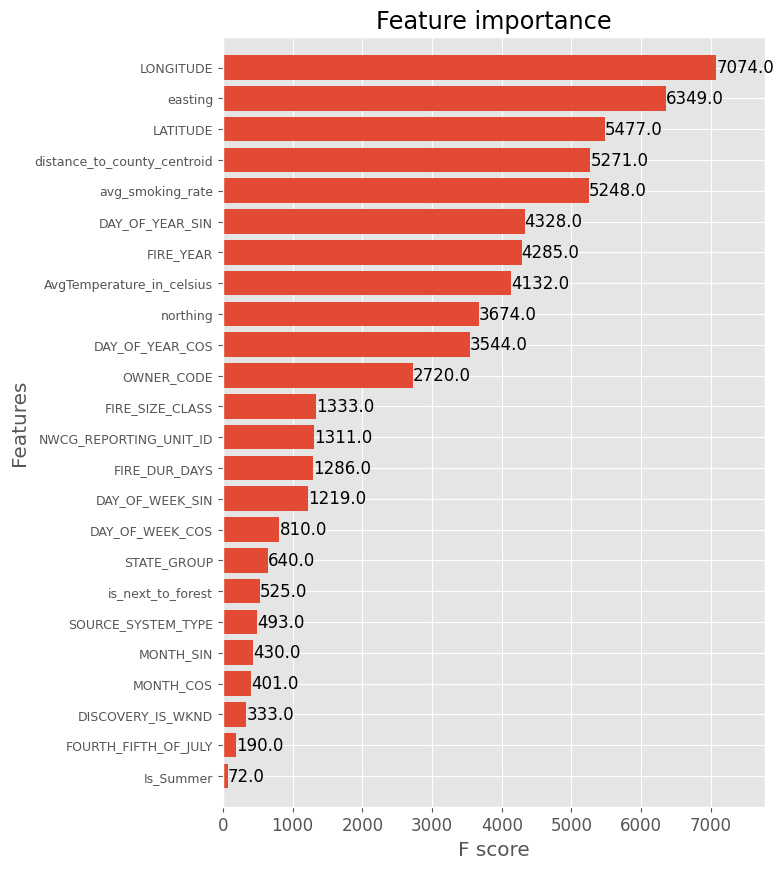

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7, 10))
plot_importance(xgb_model, ax=ax, height=0.8)
ax.tick_params(axis='y', labelsize=9)

plt.show()

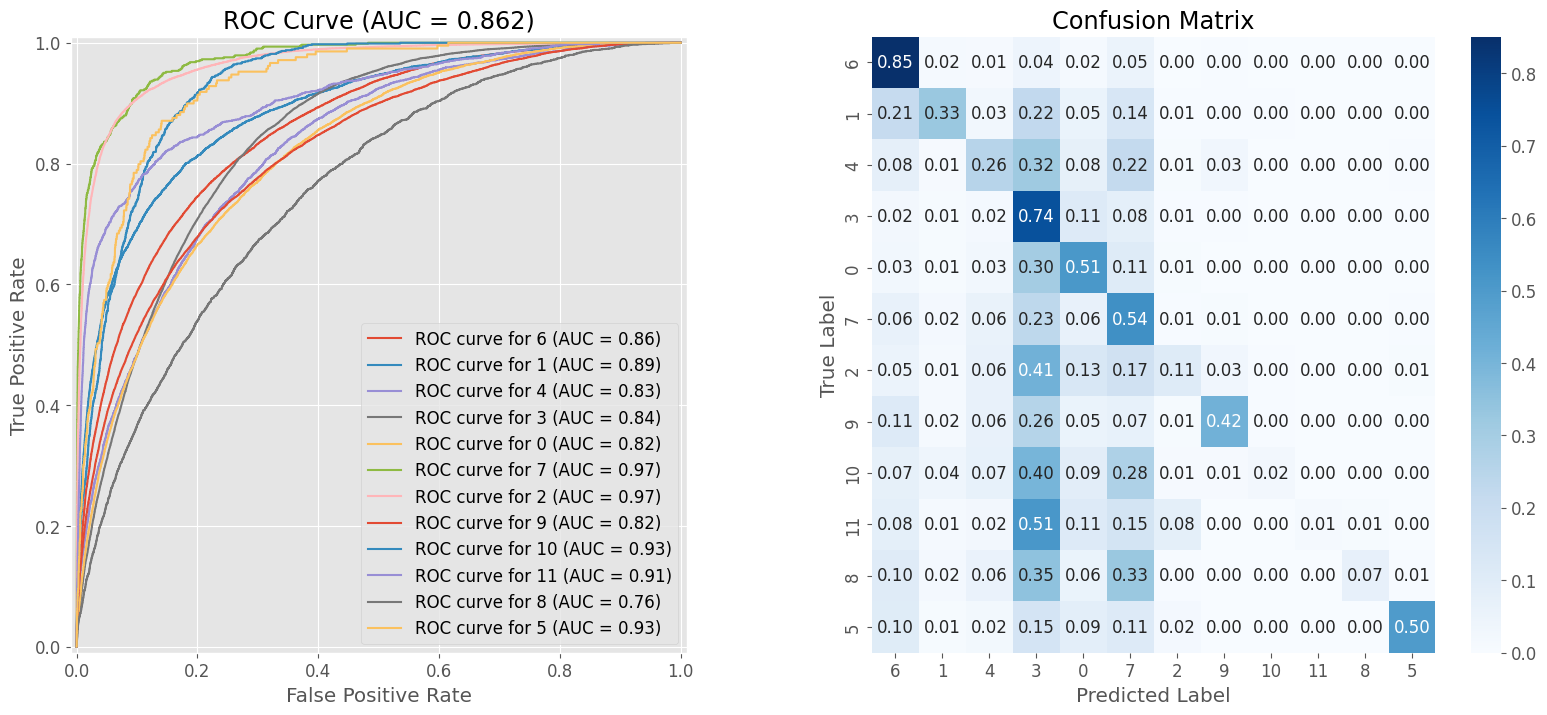

In [ ]:
plot_metrics(xgb_model_opt,X_val,y_val)

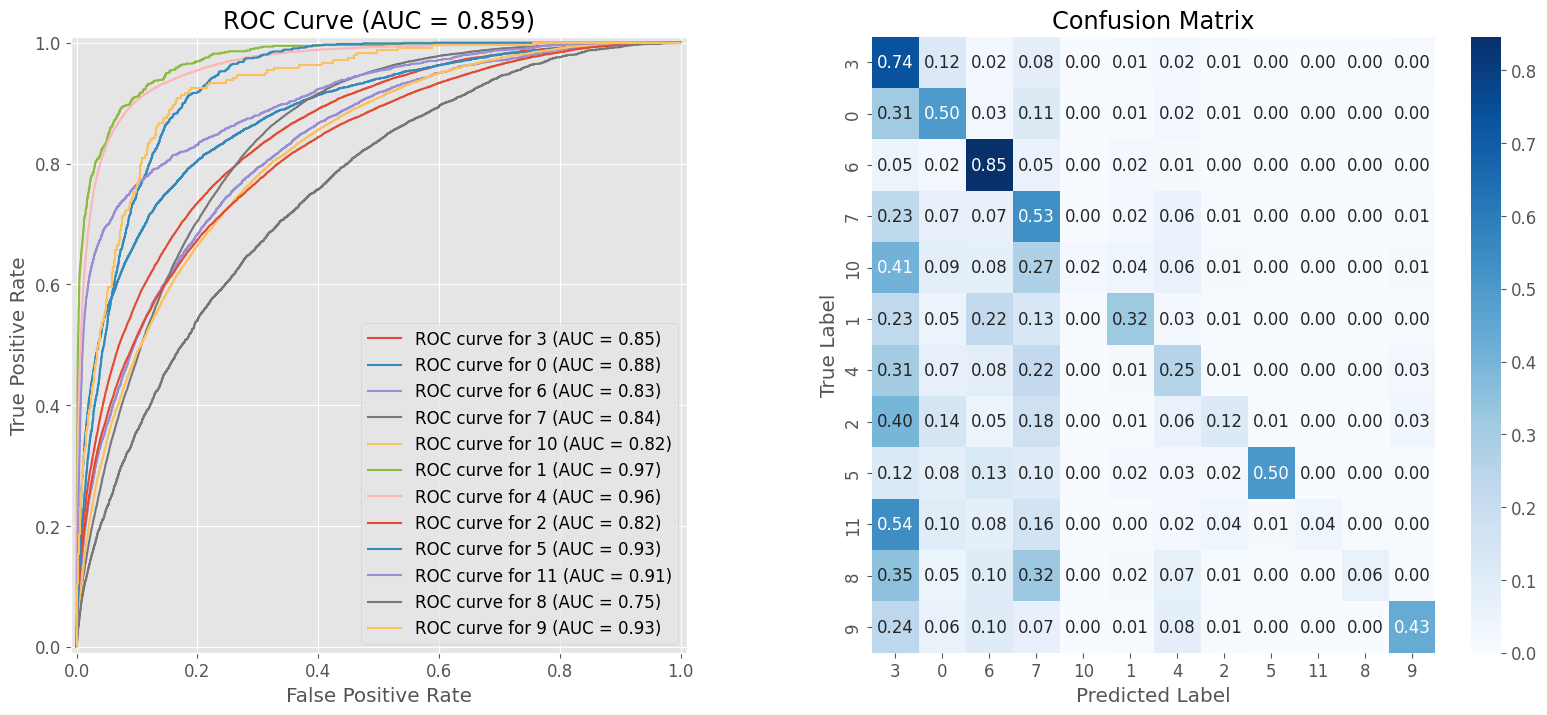

In [ ]:
plot_metrics(xgb_model_opt,test[features],test[target])